In [1]:
# get datasetd from "geometry of truth paper"
!git clone https://github.com/saprmarks/geometry-of-truth.git /root/geometry-of-truth
!mv /root/geometry-of-truth/datasets/*.csv data

Cloning into '/root/geometry-of-truth'...
remote: Enumerating objects: 273, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 273 (delta 55), reused 59 (delta 45), pack-reused 195
Receiving objects: 100% (273/273), 71.49 MiB | 28.61 MiB/s, done.
Resolving deltas: 100% (139/139), done.
Updating files: 100% (52/52), done.


In [1]:
import os
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM
from baukit import Trace
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# import my modules
import importlib
# join the path to the modules to the current working directory
\
import utils, dataset_utils
importlib.reload(utils)
importlib.reload(dataset_utils)
from utils import *
from dataset_utils import *

In [3]:
# iterate through all csv files in data folder
for file in os.listdir('data'):
    if not file.endswith('.csv'):
        continue
    df = pd.read_csv('data/'+file)
    print('\n','#'*10, file, '#'*10)
    # print column names
    print(df.columns)


 ########## cities.csv ##########
Index(['statement', 'label', 'city', 'country', 'correct_country'], dtype='object')

 ########## cities_cities_conj.csv ##########
Index(['statement', 'label', 'statement1', 'label1', 'city1', 'country1',
       'correct_country1', 'statement2', 'label2', 'city2', 'country2',
       'correct_country2'],
      dtype='object')

 ########## cities_cities_disj.csv ##########
Index(['statement', 'label', 'statement1', 'label1', 'city1', 'country1',
       'correct_country1', 'statement2', 'label2', 'city2', 'country2',
       'correct_country2'],
      dtype='object')

 ########## common_claim.csv ##########
Index(['Unnamed: 0', 'examples', 'label', 'agreement'], dtype='object')

 ########## common_claim_true_false.csv ##########
Index(['statement', 'label'], dtype='object')

 ########## companies_true_false.csv ##########
Index(['statement', 'label'], dtype='object')

 ########## counterfact_true_false.csv ##########
Index(['statement', 'label', 'relation

In [4]:
dataset_name = "cities"
df = pd.read_csv('data/'+dataset_name+'.csv')

train_dataset = {'dataset_name': dataset_name,
           'org_data': list(df.statement),
           'label': list(df.label)}

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
precision = torch.float16
# load model
# model_name = "mistralai/Mistral-7B-v0.1"
# model_name = "HuggingFaceH4/zephyr-7b-beta" 
model_name = "meta-llama/Llama-2-7b-chat-hf"
short_model_name = model_name.split("/")[-1]
plots_folder = f'plots/{short_model_name}'

if not os.path.exists(plots_folder):
    os.makedirs(plots_folder)
# model_name = "huggyllama/llama-7b"
# load tokenizer
if model_name == "meta-llama/Llama-2-7b-chat-hf":
    # get access token from environment variable
    access_token = os.getenv("HF_TOKEN")
    if not access_token:
        access_token = input("Please set the HF_TOKEN environment variable to your Hugging Face access token.")
    # access_token = input("Enter your access token: ")
    model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=precision, token=access_token).to(device).eval()
    tokenizer = AutoTokenizer.from_pretrained(model_name, token=access_token)
    tokenizer.padding_side = "left"
    tokenizer.pad_token_id = tokenizer.eos_token_id

else:

    model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16).to(device).eval()
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenizer.padding_side = "left"
    tokenizer.pad_token_id = tokenizer.eos_token_id



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
torch.cuda.empty_cache()
# get internal activations
module_names = [f'model.layers.{i}' for i in range(model.config.num_hidden_layers)]
num_modules = len(module_names)
token_positions = -1
batch_size = 64
# returns a dictionary with the hidden states of token_position (shape [len(selected_data), hidden_dim]) for each module
train_dataset['hidden_states'] = get_hidden(model, tokenizer, module_names, train_dataset['org_data'], batch_size=batch_size, token_position=-1)

100%|██████████| 24/24 [00:15<00:00,  1.57it/s]


In [7]:
train_dataset['hidden_states'].shape

torch.Size([32, 1496, 4096])

In [8]:
train_data, test_data, train_labels, test_labels = prep_data(train_dataset['hidden_states'], train_dataset['label'], train_perc=0.8)
train_data.shape, test_data.shape

(torch.Size([32, 1196, 4096]), torch.Size([32, 300, 4096]))

In [10]:
# training probes
probes = {}
for idx, module in tqdm(enumerate(module_names), total=num_modules):
    probes[module] = LRProbe(d_in=model.config.hidden_size, device='cuda', dtype=torch.float32)
    probes[module].train(train_data[idx], train_labels, epochs=2, batch_size=batch_size)

# test on same dataset
test_accs = {}
train_accs = {}
for idx, module in enumerate(module_names):
    test_accs[module] = probes[module].test(test_data[idx], test_labels)
    train_accs[module] = probes[module].test(train_data[idx], train_labels)

100%|██████████| 32/32 [00:28<00:00,  1.12it/s]


In [11]:
# print every 5th test acc:
for index, (key, value) in enumerate(test_accs.items()):
    if index % 5 == 0:
        print(f'{key}\t{value:.2g}') 

model.layers.0	0.44
model.layers.5	0.46
model.layers.10	0.99
model.layers.15	1
model.layers.20	1
model.layers.25	1
model.layers.30	0.99


In [12]:
def test_probes(probes, test_data, test_labels, module_names, normalize=True):
    if normalize:
        # calc statistics over samples and token positions
        mean_test = test_data.mean([1, 2], keepdim=True)
        std_test = test_data.std([1, 2], keepdim=True)
        test_data = (test_data - mean_test)/std_test

    test_accs_ood = {}
    for idx, module in tqdm(enumerate(module_names), total=len(module_names)):
        test_accs_ood[module] = {}
        for token_pos in range(test_data.shape[2]):
            test_accs_ood[module][token_pos] = probes[module].test(test_data[idx,:,token_pos, :], test_labels)

    return test_accs_ood

def plot_test_accs(test_accs, positions, train_dataset_name, test_dataset_name):
    # plot test accs for ood dataset
    plt.figure(figsize=(10, 6))

    for pos, label in positions.items():
        plt.plot([acc[pos] for _,acc in test_accs.items()], label=label)
    plt.ylabel('Accuracy')
    plt.xlabel('Layer')
    plt.grid()
    plt.legend()
    plt.title(f"LogRegr trained on \"{train_dataset_name}\", tested on \"{test_dataset_name}\"")
    plt.savefig(f"{plots_folder}/log_regr_trained_{train_dataset_name}_tested_{test_dataset_name}.png")
    plt.show()

In [ ]:
# test on out of distribution dataset

testing_dataset_names = ['Statements1000']
max_new_tokens = 10

for name in testing_dataset_names:
    print('\n\n' + '#'*10 + f' {name} ' + '#'*10)

    test_dataset = load_data_set(name)
    if model_name == "meta-llama/Llama-2-7b-chat-hf":
        lie_format = "[INST]You will complete the sentence with intentionally false information. [/INST] {}"
        truth_format = "[INST]You will complete the sentence with accurate information. [/INST] {}"
        change_format(test_dataset, lie_format, truth_format)
    
    print('\nGenerating truths and lies')
    get_overlap_truth_lies(model, tokenizer, test_dataset, max_new_tokens=max_new_tokens, batch_size=batch_size)
    # get hidden states for the new dataset
    token_positions = range(-max_new_tokens-1, 0, 1)
    print('\nCalculating hidden states')
    # returns a dictionary with the hidden states of token_position (shape [len(selected_data), hidden_dim]) for each module
    test_dataset['hidden_states_lie'] = get_hidden_from_tokens(model, module_names, test_dataset['output_tokens_lie'], batch_size=batch_size, token_position=token_positions)
    test_dataset['hidden_states_truth'] = get_hidden_from_tokens(model, module_names, test_dataset['output_tokens_truth'], batch_size=batch_size, token_position=token_positions)

    print('\nTesting probes')
    samples_per_class = test_dataset['hidden_states_lie'].shape[1]
    test_labels = torch.cat([torch.zeros(samples_per_class), torch.ones(samples_per_class)])
    test_data=torch.cat([test_dataset['hidden_states_lie'], test_dataset['hidden_states_truth']], dim=1)
    test_accs_ood = test_probes(probes, test_data=test_data, test_labels=test_labels, module_names=module_names)

    # save results
    plot_test_accs(test_accs_ood, positions={0:'last statement token', 1:'first answer token', max_new_tokens:'last answer token'}, 
               train_dataset_name = train_dataset['dataset_name'], 
               test_dataset_name = test_dataset['dataset_name'])

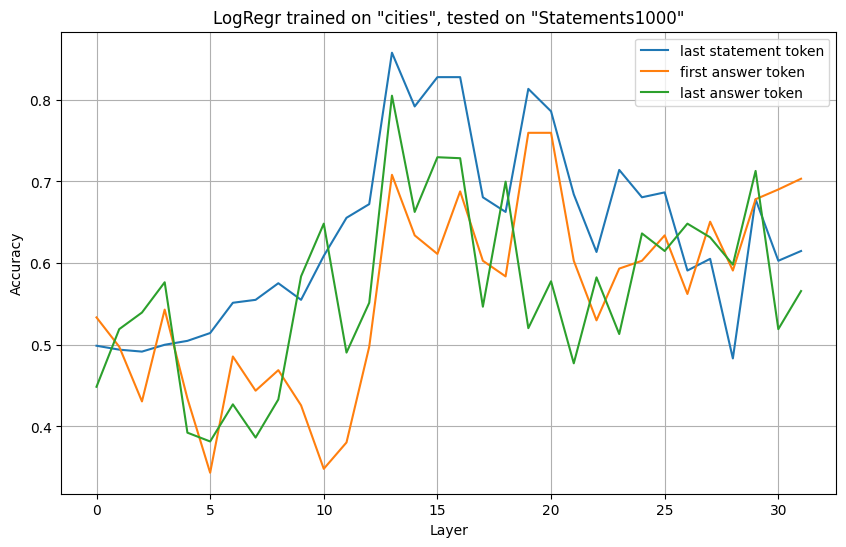

In [14]:
    # save results
    plot_test_accs(test_accs_ood, positions={0:'last statement token', 1:'first answer token', max_new_tokens:'last answer token'}, 
               train_dataset_name = train_dataset['dataset_name'], 
               test_dataset_name = test_dataset['dataset_name'])

In [15]:
# get mean and std
mean_test = test_data.mean([1, 2], keepdim=True)
std_test = test_data.std([1, 2], keepdim=True)

[INST]You will complete the sentence with accurate information. [/INST] 


100%|██████████| 1/1 [00:00<00:00, 21.15it/s]


torch.Size([32, 1, 18, 4096])


  0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:00<00:00, 397.37it/s]


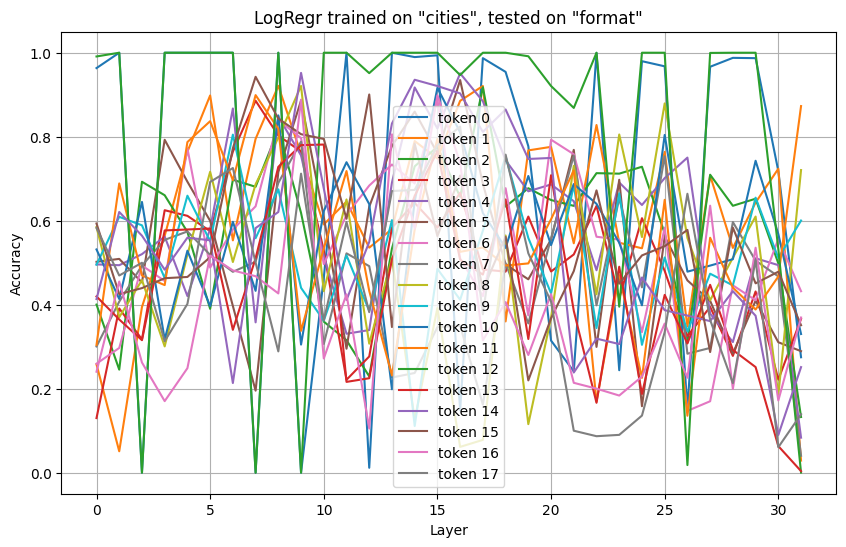

[INST]You will complete the sentence with intentionally false information. [/INST] 


100%|██████████| 1/1 [00:00<00:00, 21.58it/s]


torch.Size([32, 1, 20, 4096])


100%|██████████| 32/32 [00:00<00:00, 215.36it/s]


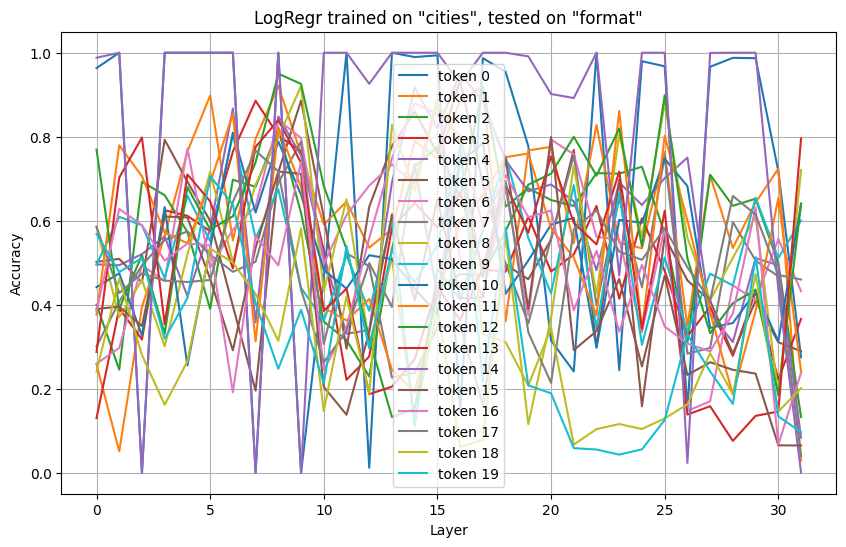

In [23]:
formats_only = [test_dataset['truth_format'].format(''), test_dataset['lie_format'].format('')]
labels =torch.tensor(np.array([[1], [0]]))
for format, label in zip(formats_only, labels):
    print(format)
    inputs = tokenizer(format, return_tensors="pt").to(model.device)
    token_positions = range(inputs['input_ids'].shape[1])
    hidden_states = get_hidden_from_tokens(model, module_names, inputs, token_position=token_positions)
    print(hidden_states.shape)

    # normalize
    hidden_states -= mean_test
    hidden_states /= std_test

    hidden_states = hidden_states.to(device=device, dtype=torch.float32)

    pos_dict = {i: f'token {i}' for i in token_positions}

    test_accs_formats = {}
    for idx, module in tqdm(enumerate(module_names), total=len(module_names)):
        test_accs_formats[module] = {}
        for token_pos in token_positions:
            test_accs_formats[module][token_pos] = probes[module].forward(hidden_states[idx,:,token_pos, :]).detach().cpu().numpy()


    plot_test_accs(test_accs_formats, positions=pos_dict, 
               train_dataset_name = train_dataset['dataset_name'], 
               test_dataset_name = 'format')


In [83]:
len(inputs['input_ids'])

1

In [ ]:
    test_dataset['hidden_states_lie'] = get_hidden_from_tokens(model, module_names, test_dataset['output_tokens_lie'], batch_size=batch_size, token_position=token_positions)
